In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import csv
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss 
def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    if max_val - min_val != 0:
        normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    else: normalized_list = np.array(input_list)/max_val
    return normalized_list
def remap_value(value, input_range, output_range):
    input_min, input_max = input_range
    output_min, output_max = output_range

    mapped_value = (value - input_min) / (input_max - input_min) * (output_max - output_min) + output_min
    return mapped_value

def custom_remap(value):
    if value > 0 and value<0.2:
        return remap_value(value, (0, 0.2), (0, 0.1))
    return value
counts = 0

# Tain

## Initial count file

In [4]:
pth = 'Data/tomo_train_240608/train/trained_result/'
import pickle
data_index = {
    'counts': 1,
    'mlp_0': {'lr':  0.005, 'epochs': 150}
}
try: dindex = pickle.load(open(pth+'dindex.pkl', 'rb'))
except: pickle.dump(data_index, open(pth+'dindex.pkl', 'wb'))

## Load train set

Use matlab script `mat2txt.m` and `text_convert.py` to convert `.mat` data to I: ...; Q: ...

In [5]:
pth = 'Data/tomo_train_240608/train/'
train_filename = {'g': ['train_ground.csv'], 'e': ['train_excited.csv']}
# train_filename = {'g': ['HF_ground.csv'], 'e': ['HF_excited.csv']}

# Create (key, value) pair
chara_lst = []; label_lst = []
for keys in train_filename.keys():
    for filename in train_filename[keys]:
        data = pd.read_csv(pth+filename, header=None)
        chara_set=data.iloc[:,:].to_numpy().astype(float)
        if keys == 'e':
            label_set=np.ones(data.shape[0], dtype=int).T
        elif keys == 'g':
            label_set=np.zeros(data.shape[0], dtype=int).T
        else:
            raise(ValueError(f'Invalid keys {keys}'))
        chara_lst.append(chara_set)
        label_lst.append(label_set)
chara_arr = np.vstack(chara_lst); label_arr = np.hstack(label_lst)

X_train, X_test, Y_train, Y_test = train_test_split(chara_arr, label_arr, test_size=0.2, random_state=3)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
trainset = TensorDataset(X_train_tensor, Y_train_tensor)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

## Setup train

### Define model, and train function

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2000, 900), 
            nn.ReLU(),
            nn.Linear(900,250), 
            nn.ReLU(),
            nn.Linear(250,50),
            nn.ReLU(),
            nn.Linear(50, 2) 
        )

    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs
    
def train_mlp(learning_rate= 0.005, epochs= 150):
    """
    learning_rate: float
        value between 0 and 1

    epochs: int
        number of training iterations.
    """
    config = {'lr': learning_rate, 'epochs': epochs}
    mlp = MLP()
    criterion = nn.CrossEntropyLoss(reduction='sum')  # Using cross entropy function for muti-classification problem
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)  # Adam optimizer
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # whether use GPU or not

    for i in range(epochs):
        running_loss = 0.
        running_acc = 0.

        for (inputs, labels) in trainloader:
            optimizer.zero_grad()
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predict = torch.max(outputs, 1)
            correct_num = (predict == labels).sum()
            running_acc += correct_num.item()

        running_loss /= len(trainset)
        running_acc /= len(trainset)
        if (i+1)%10 ==0:
            print("[%d/%d] Loss:%.5f, Acc:%.2f" % (i+1, epochs, running_loss, 100 * running_acc))

    return mlp, config

### Run training function and save trained weight

In [11]:
mlp_model, config = train_mlp(learning_rate= 0.002, epochs= 300)

dindex = pickle.load(open(pth+'trained_result/dindex.pkl', 'rb'))
counts = dindex['counts']
fname = f'mlp_LF_{str(counts)}'
dindex[fname]= config
dindex['counts'] += 1
pickle.dump(dindex, open(pth+'trained_result/dindex.pkl', 'wb'))

torch.save(mlp_model, pth+f'trained_result/'+fname+'.pkl')

[10/300] Loss:0.00004, Acc:100.00
[20/300] Loss:0.00002, Acc:100.00
[30/300] Loss:0.00001, Acc:100.00
[40/300] Loss:0.00001, Acc:100.00
[50/300] Loss:0.00000, Acc:100.00
[60/300] Loss:0.00000, Acc:100.00
[70/300] Loss:0.00000, Acc:100.00
[80/300] Loss:0.00000, Acc:100.00
[90/300] Loss:0.00000, Acc:100.00
[100/300] Loss:0.00000, Acc:100.00
[110/300] Loss:0.00000, Acc:100.00
[120/300] Loss:0.00000, Acc:100.00
[130/300] Loss:0.00000, Acc:100.00
[140/300] Loss:0.00000, Acc:100.00
[150/300] Loss:0.00000, Acc:100.00
[160/300] Loss:0.00000, Acc:100.00
[170/300] Loss:0.00000, Acc:100.00
[180/300] Loss:0.00000, Acc:100.00
[190/300] Loss:0.00000, Acc:100.00
[200/300] Loss:0.00000, Acc:100.00
[210/300] Loss:0.00000, Acc:100.00
[220/300] Loss:0.00000, Acc:100.00
[230/300] Loss:0.00000, Acc:100.00
[240/300] Loss:0.00000, Acc:100.00
[250/300] Loss:0.00000, Acc:100.00
[260/300] Loss:0.00000, Acc:100.00
[270/300] Loss:0.00000, Acc:100.00
[280/300] Loss:0.00000, Acc:100.00
[290/300] Loss:0.00000, Acc:1

# Test

## Define test function

In [12]:
label2out = {'excited':1, 'ground':0}

def test_trmnn(model, testloader, test_label):
    if test_label in label2out.keys(): out_val = label2out[test_label]
    else: out_val = 0.5
    running_acc = 0.
    list=[]
    lens=0
    for (inputs, labels) in testloader:
        outputs = model(inputs)
        # outputs = torch.softmax(outputs, 1) # Turn of when do Rabi
        result, predict = torch.max(outputs, 1)
        # list.append(outputs[:,1].item())
        list.append(predict.item())
        if labels.item() ==out_val and predict.item()==out_val:
            correct_num = (predict == labels).sum()
            running_acc += correct_num.item()
            lens=lens+1
    running_acc /= 2000 
    return running_acc*100,list

def test_fnn(model, testloader, test_label):
    if test_label in label2out.keys(): out_val = label2out[test_label]
    else: out_val = 0.5
    running_acc = 0.
    list=[]
    lens=0
    for (inputs, labels) in testloader:
        outputs = model(inputs)
        outputs = torch.softmax(outputs, 1)
        result, predict = torch.max(outputs, 1)
        list.append(outputs[:,1].item())
        if labels.item() ==out_val and predict.item()==out_val:
            correct_num = (predict == labels).sum()
            running_acc += correct_num.item()
            lens=lens+1
    running_acc /= 2000
    return running_acc*100,list

## Load test set

In [13]:
pth = 'Data/tomo_train_240608/test/'

## Notice that, the time represents the number average per point in a 200 ns Rabi 
## population vs. time sequence. The standard form for a rabi data is taken for 200ns, 40 population points, and total number of used IQ data groups are 40*time
## Here, the IQ data point per test_label is 1000, therefore the maximum of time is 25

time=25; test_label = 'pix'

test_filenmae = ['test_'+test_label+'.csv']; test_lst = []
for filename in test_filenmae:
    test_lst.append(pd.read_csv(pth+filename, header=None))
test_data=pd.concat(test_lst)

X_test = test_data.iloc[0:40*time,0:2000].to_numpy().astype(float) # 0:2000 means data set size is 2000
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
if test_label=='ground': Y_test_tensor = torch.zeros(time*40,dtype=torch.long).reshape((time*40,1))
elif test_label=='excited': Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
else: Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
testset = TensorDataset(X_test_tensor, Y_test_tensor)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

## Test and plot

### Single test

Test accuracy
TRMNN: 0.0%
FNN: 0.0%
(Mean, var) of pix result are:
TRMNN: (0.9, 0.09)
FNN: (0.8859351129264443, 0.06884898387453842)


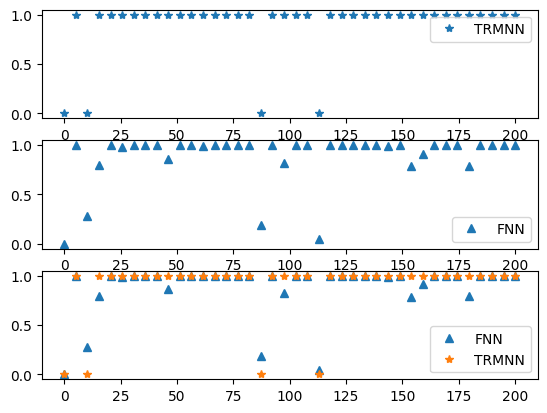

In [15]:
pth = 'Data/tomo_train_240608/train/trained_result/'
mlp_model = torch.load(pth+'mlp_LF_6.pkl')

test_accuracy_trmnn, trnmm_list = test_trmnn(mlp_model, testloader, test_label)
test_accuracy_fnn, fnn_list = test_fnn(mlp_model, testloader, test_label)

print("Test accuracy")
print(f'TRMNN: {test_accuracy_trmnn}%')
print(f'FNN: {test_accuracy_fnn}%')

result_trmnn = np.zeros(40,dtype= float)
for i in range(len(trnmm_list)):
    result_trmnn[i%40]=result_trmnn[i%40]+trnmm_list[i]
result_trmnn/time
result_trmnn =normalize_list(result_trmnn)

result_fnn = np.zeros(40,dtype= float)
for i in range(len(fnn_list)):
    result_fnn[i%40]=result_fnn[i%40]+fnn_list[i]
result_fnn/time
result_fnn =normalize_list(result_fnn)


print(f'(Mean, var) of {test_label} result are:')
print(f'TRMNN: ({np.average(result_trmnn)}, {np.var(result_trmnn)})')
print(f'FNN: ({np.average(result_fnn)}, {np.var(result_fnn)})')

x=np.linspace(0,200,len(result_fnn))
plt.figure(555)

plt.subplot(3,1,1)
plt.plot(x,result_trmnn,'*',linewidth =0.5,label='TRMNN')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x,result_fnn,'^',linewidth =0.5,label='FNN')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x,result_fnn,'^',linewidth =0.5,label='FNN')
plt.plot(x,result_trmnn,'*',linewidth =0.5,label='TRMNN')
plt.legend()
plt.show()


### Do multiple test loop and save the data 

#### Init count file

In [27]:
pth = 'Data/tomo_train_240608/test/test_result/'
import pickle
data_index = {
    'counts': 1,
}
try: dindex = pickle.load(open(pth+'dindex.pkl', 'rb'))
except: pickle.dump(data_index, open(pth+'dindex.pkl', 'wb'))

#### Run loop

In [31]:
data = dict(); test_label_set = ['ground', 'pix', 'piy', 'halfpix', 'halfpiy', 'halfpixy', 'halfpiyx']

time=25

pth = 'Data/tomo_train_240608/train/trained_result/'

which_net = 'mlp_2'
mlp_model = torch.load(pth+which_net+'.pkl')

data['config'] = {}; data['data'] = {}
data['config']['pth'] = pth
data['config']['model'] =which_net
data['config']['test_lb'] = test_label_set
data['config']['time'] = time

pth = 'Data/tomo_train_240608/test/'

for test_label in test_label_set:
    test_filenmae = ['test_'+test_label+'.csv']; test_lst = []
    for filename in test_filenmae:
        test_lst.append(pd.read_csv(pth+filename, header=None))
    test_data=pd.concat(test_lst)
    X_test = test_data.iloc[0:40*time,0:2000].to_numpy().astype(float) # 0:2000 means data amount is 2000
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    if test_label=='ground': Y_test_tensor = torch.zeros(time*40,dtype=torch.long).reshape((time*40,1))
    elif test_label=='excited': Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
    else: Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
    testset = TensorDataset(X_test_tensor, Y_test_tensor)
    testloader = DataLoader(testset, batch_size=1, shuffle=False)

    test_accuracy_trmnn, trnmm_list = test_trmnn(mlp_model, testloader, test_label)
    test_accuracy_fnn, fnn_list = test_fnn(mlp_model, testloader, test_label)
    result_trmnn = normalize_list(trnmm_list)
    result_fnn = normalize_list(fnn_list)
    data['data'][test_label] = {}
    data['data'][test_label]['trmnn'] = {'data_list': result_trmnn, 'avg': np.average(result_trmnn), 'var': np.var(result_trmnn)}
    data['data'][test_label]['fnn'] = {'data_list': result_fnn, 'avg': np.average(result_fnn), 'var': np.var(result_fnn)}

pth = 'Data/tomo_train_240608/test/test_result/'
dindex = pickle.load(open(pth+ 'dindex.pkl', 'rb'))
iidx = dindex['counts']
pickle.dump(data, open(pth + which_net+f'_testresult_{iidx}.pkl', 'wb'))
dindex['counts'] += 1; pickle.dump(dindex, open(pth+ 'dindex.pkl', 'wb'))

# State tomo

Script borrowed from: qtrlb [https://github.com/Zihao96/qtrlb], thanks Zihao Wang

In [37]:
from state_tomography_tools import calculate_qubit_density_matrix, make_dm_physical
from qutip import *
def rx(theta):
    return (-1j*theta/2*sigmax()).expm()
def ry(theta):
    return (-1j*theta/2*sigmay()).expm()

# Single qubit tomo gate set
single_qb_tomo_gates_list = [
    {'Q1': ['I']},
    {'Q1': ['X90_01']},
    {'Q1': ['Y90_01']}
]
# Two qubit tomo gate set
two_qb_tomo_gates_list =[
            {'Q0': ['I'], 'Q1': ['I']},
            {'Q0': ['I'], 'Q1': ['X90_01']},
            {'Q0': ['I'], 'Q1': ['Y90_01']},
            {'Q0': ['X90_01'], 'Q1': ['I']},
            {'Q0': ['X90_01'], 'Q1': ['X90_01']},
            {'Q0': ['X90_01'], 'Q1': ['Y90_01']},
            {'Q0': ['Y90_01'], 'Q1': ['I']},
            {'Q0': ['Y90_01'], 'Q1': ['X90_01']},
            {'Q0': ['Y90_01'], 'Q1': ['Y90_01']},
        ]

## Read data from network output

In [45]:
dm_set = {'trmnn': {'rho1': np.ndarray(shape=(2, 3), dtype=float), 'rho2': np.ndarray(shape=(2, 3), dtype=float)},
                'fnn': {'rho1': np.ndarray(shape=(2, 3), dtype=float), 'rho2': np.ndarray(shape=(2, 3), dtype=float)}
                }

pth = 'Data/tomo_train_240608/test/test_result/'
d = pickle.load(open(pth+'mlp_2_testresult_1.pkl', 'rb'))

state_idx_set = {'rho1': {'I': 'halfpix', 'X90_01': 'pix', 'Y90_01': 'halfpixy'},
'rho2': {'I': 'halfpiy', 'X90_01': 'halfpiyx', 'Y90_01': 'piy'}}

var_set = {}

for st in state_idx_set.keys():
    var_set[st] = {}
    for ii, kk in enumerate(state_idx_set[st]):
        pulse_key = state_idx_set[st][kk]
        var_set[st][pulse_key] = {}
        for kks in ['trmnn', 'fnn']:
            p1 = d['data'][pulse_key][kks]['avg']
            p0 = 1-p1
            dm_set[kks][st][:, ii] = [p0, p1]
            try:
               var_set[st][pulse_key][kks].append(d['data'][pulse_key][kks]['var'])
            except: 
                var_set[st][pulse_key][kks] = []

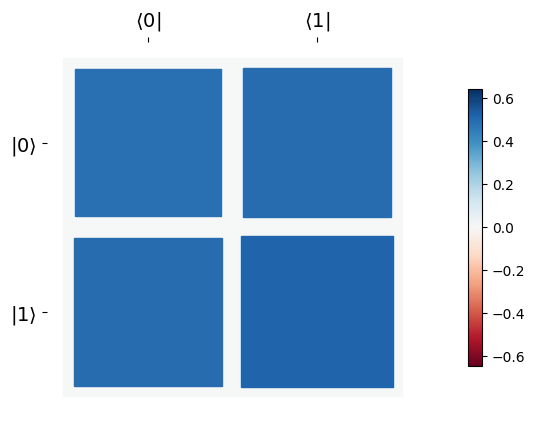

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.484+0.j    0.016+0.496j]
 [0.016-0.496j 0.516+0.j   ]]

In [68]:
dm_trmnn_rho1 = Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['trmnn']['rho1'], single_qb_tomo_gates_list)))
fig, ax = hinton(dm_trmnn_rho1)
plt.show()
dm_trmnn_rho1

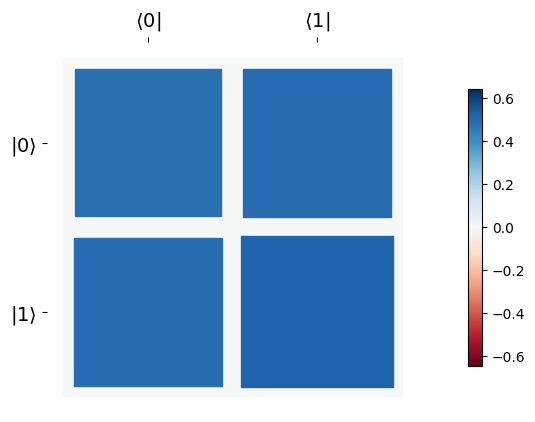

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.48378861+0.j         0.01963965+0.49551702j]
 [0.01963965-0.49551702j 0.51621139+0.j        ]]

In [69]:
dm_fnn_rho1 = Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['fnn']['rho1'], single_qb_tomo_gates_list)))
fig, ax = hinton(dm_fnn_rho1)
plt.show()
dm_fnn_rho1

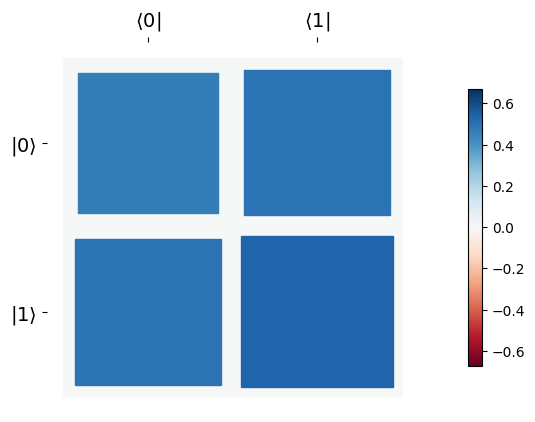

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.46244304+0.j         0.49417056-0.06621885j]
 [0.49417056+0.06621885j 0.53755696+0.j        ]]

In [70]:
dm_trmnn_rho2 = Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['trmnn']['rho2'], single_qb_tomo_gates_list)))
fig, ax = hinton(dm_trmnn_rho2)
plt.show()
dm_trmnn_rho2

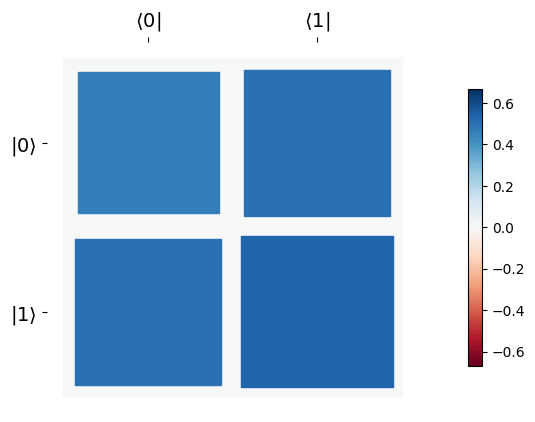

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.46491885+0.j         0.49431031-0.06653296j]
 [0.49431031+0.06653296j 0.53508115+0.j        ]]

In [71]:
dm_fnn_rho2 = Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['fnn']['rho2'], single_qb_tomo_gates_list)))
fig, ax = hinton(dm_fnn_rho2)
plt.show()
dm_fnn_rho2

## State Fidelity plot

### Calculate ideal case

In [50]:
rho1_id = ket2dm((basis(2,0)-1j*basis(2,1))/np.sqrt(2))
rho2_id = ket2dm((basis(2,0)+1*basis(2,1))/np.sqrt(2))
rho_id_set = {'rho1': rho1_id, 'rho2': rho2_id}
Flst = [[],[]]
for i, keys in enumerate(['rho1', 'rho2']):
    rho_id = rho_id_set[keys]
    Flst[i].append(fidelity(rho_id, Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['trmnn'][keys], single_qb_tomo_gates_list)))))
    Flst[i].append(fidelity(rho_id, Qobj(make_dm_physical(calculate_qubit_density_matrix(dm_set['fnn'][keys], single_qb_tomo_gates_list)))))

### make a plot

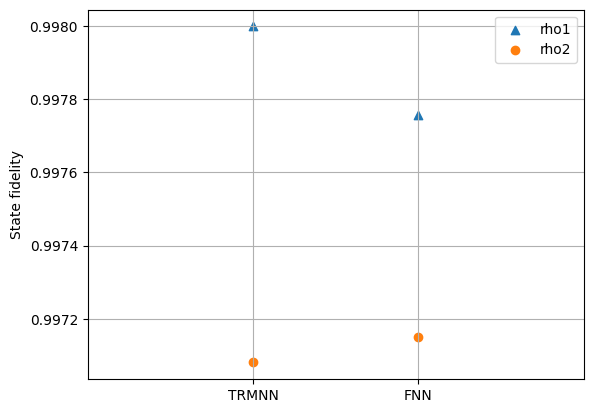

In [57]:
x = np.linspace(0,1,2)
plt.scatter(x,Flst[0], marker='^', label='rho1')
plt.scatter(x,Flst[1], label='rho2')
plt.xticks([0,1], ['TRMNN', 'FNN'])
plt.ylabel('State fidelity')
plt.legend()
plt.xlim([-1,2])
plt.grid()
plt.show()

## Plot network output mean, var


### plot var

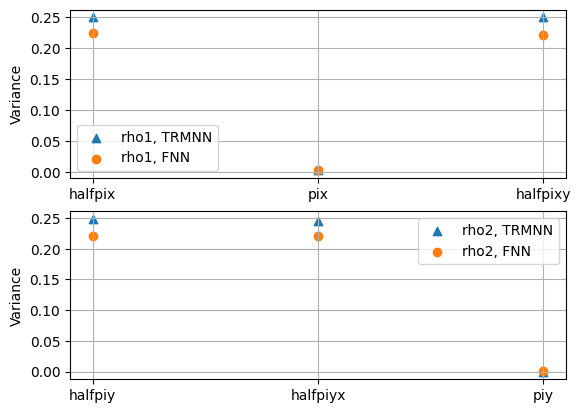

In [58]:
var_set1 = [[],[]]; var_set2 = [[],[]]; pulse_key_set = [[], []]
for iii,st in enumerate(state_idx_set.keys()):
    for ii, kk in enumerate(state_idx_set[st]):
        pulse_key = state_idx_set[st][kk]
        pulse_key_set[iii].append(pulse_key)
        for kks in ['trmnn', 'fnn']:
            p1 = d['data'][pulse_key][kks]['avg']
            p0 = 1-p1
            dm_set[kks][st][:, ii] = [p0, p1]
            if st == 'rho1':
                record_set = var_set1
            else: record_set = var_set2
            if kks == 'fnn': record_set[1].append(d['data'][pulse_key][kks]['var'])
            else:  record_set[0].append(d['data'][pulse_key][kks]['var'])

x = np.linspace(0, 2,3)
plt.subplot(2,1,1)
plt.scatter(x, var_set1[0], marker='^', label = "rho1, TRMNN")
plt.scatter(x, var_set1[1], label = "rho1, FNN")
plt.xticks([0,1,2], pulse_key_set[0])
plt.grid()
plt.legend()
plt.ylabel('Variance')

plt.subplot(2,1,2)
plt.scatter(x, var_set2[0],marker='^', label = "rho2, TRMNN")
plt.scatter(x, var_set2[1], label = "rho2, FNN")
plt.xticks([0,1,2], pulse_key_set[1])
plt.ylabel('Variance')
plt.grid()
plt.legend()
plt.show()


### plot mean

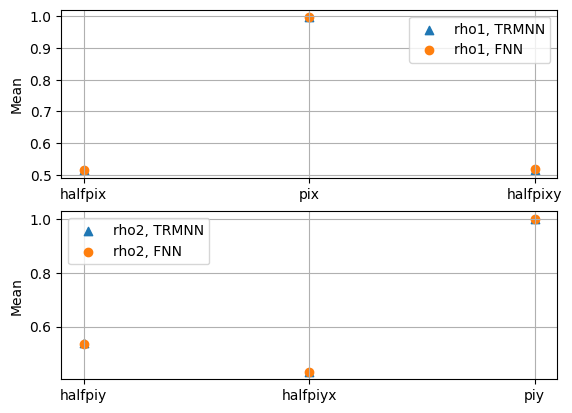

In [59]:
avg_set1 = [[],[]]; avg_set2 = [[],[]]; pulse_key_set = [[], []]
for iii,st in enumerate(state_idx_set.keys()):
    for ii, kk in enumerate(state_idx_set[st]):
        pulse_key = state_idx_set[st][kk]
        pulse_key_set[iii].append(pulse_key)
        for kks in ['trmnn', 'fnn']:
            p1 = d['data'][pulse_key][kks]['avg']
            p0 = 1-p1
            dm_set[kks][st][:, ii] = [p0, p1]
            if st == 'rho1':
                record_set = avg_set1
            else: record_set = avg_set2
            if kks == 'fnn': record_set[1].append(d['data'][pulse_key][kks]['avg'])
            else:  record_set[0].append(d['data'][pulse_key][kks]['avg'])

x = np.linspace(0, 2,3)
plt.subplot(2,1,1)
plt.scatter(x, avg_set1[0], marker='^', label = "rho1, TRMNN")
plt.scatter(x, avg_set1[1], label = "rho1, FNN")
plt.xticks([0,1,2], pulse_key_set[0])
plt.grid()
plt.legend()
plt.ylabel('Mean')

plt.subplot(2,1,2)
plt.scatter(x, avg_set2[0], marker='^', label = "rho2, TRMNN")
plt.scatter(x, avg_set2[1], label = "rho2, FNN")
plt.xticks([0,1,2], pulse_key_set[1])
plt.ylabel('Mean')
plt.grid()
plt.legend()
plt.show()